In [40]:
import torch
import random
import lib

#### Straightforward Implementation

In [41]:
def synthetic_regression_data(w, b, num_examples):
    """generate y=Xw+b with noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_regression_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.0940, -1.3954]) 
label: tensor([6.7586])


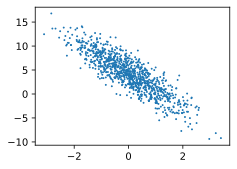

In [42]:
# check the relationship between second feature and label, intuitively
lib.set_figsize()
lib.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [43]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # during training, shuffle the dataset
    # notice that during testing, we do not need to shuffle the dataset
    random.shuffle(indices)
    # return iterable each time we call the function (helps to reduce memory usage)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [44]:
batch_size = 10
# check the batch style
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0024, -1.4411],
        [ 1.5646,  0.6143],
        [ 1.2652,  0.3052],
        [ 0.1081, -1.1688],
        [ 1.1778,  1.0548],
        [-0.9306,  1.0047],
        [ 0.2129,  1.2440],
        [ 0.3053,  1.8466],
        [ 0.0725, -0.1743],
        [-0.3476,  0.6157]]) 
 tensor([[ 9.0984],
        [ 5.2234],
        [ 5.7053],
        [ 8.3753],
        [ 2.9597],
        [-1.0819],
        [ 0.3903],
        [-1.4631],
        [ 4.9369],
        [ 1.4190]])


In [45]:
# initialize model parameters
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [46]:
# define this simple model
def linreg(X, w, b):
    """linear regression model"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    """mini-batch sgd"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [47]:
# define hyperparameters
lr = 0.03
num_epochs = 3
net = linreg  # our defined model
loss = squared_loss  # 0.5 (y-y')^2

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # l.shape: (batch_size, 1)

        l.sum().backward()  # compute gradient on l with respect to [w, b]
        # l.backward(torch.ones_like(l))  # compute gradient on l with respect to [w, b]

        sgd([w, b], lr, batch_size)  # update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035307
epoch 2, loss 0.000129
epoch 3, loss 0.000055


In [48]:
print(f'error of w: {true_w - w.reshape(true_w.shape)}')
print(f'error of b: {true_b - b}')
# note that really close

error of w: tensor([ 5.4121e-05, -6.4850e-04], grad_fn=<SubBackward0>)
error of b: tensor([0.0008], grad_fn=<RsubBackward1>)


#### OO Implementation

In [ ]:
generate_data = lib.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
print('features:', generate_data.X[0],'\nlabel:', generate_data.y[0])

In [ ]:
class LinearRegressionScratch(lib.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        """The linear regression model."""
        return torch.matmul(X, self.w) + self.b

    def loss(self, y_hat, y):
        l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
        return l.mean()

In [ ]:
class SGD(lib.HyperParameters):
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [ ]:
@lib.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [ ]:
@lib.add_to_class(lib.Trainer)
def prepare_batch(self, batch):
    return batch

@lib.add_to_class(lib.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

In [ ]:
%matplotlib inline
model = LinearRegressionScratch(2, lr=0.03)
data = lib.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = lib.Trainer(max_epochs=3)
# trainer.fit(model, data)

In [ ]:
trainer.fit(model, data)